# Fake and Real News

Model to determine if an article is fake news or not ?

## Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf

In [5]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU Available, switching to CPU Version")

No GPU Available, switching to CPU Version


## Load the dataset and validate the data load

We will load the individual dataset, create a target attribute which will indicate 1 if the news is fake. Combine both the dataframes and create the combined dataframe for modelling

In [30]:
# Load the fake and real news datasets
fake_news = pd.read_csv("resources/Fake.csv")
fake_news["fake"] = 1

# Load the real news 
real_news = pd.read_csv("resources/True.csv")
real_news["fake"] = 0

# We will join the two dataframes and create the combined one for modelling

news = pd.concat([fake_news, real_news])
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


#### We will combine the title and text column

In [31]:
news['text'] = news['title'] + news['text']
news.drop(labels=['title'], axis=1, inplace=True)

news.head()

,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,News,"December 25, 2017",1


## Exploratory Data Analysis - Data Visualizations

#### Explore the target variable

Distributions...
1    23481
0    21417
Name: fake, dtype: int64


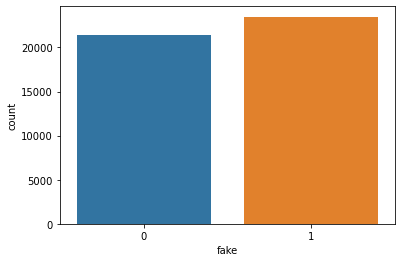

In [23]:
# Explore the target variable
sns.countplot(x='fake', data=news)
print("Distributions...")
print(news['fake'].value_counts())

We see good distibution of data in both the classes

#### Explore at least 2 texts from each class

In [27]:
# Explore 2 texts for the fake dataset
news[news['fake'] == 1]['text'].head(2)

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
Name: text, dtype: object

In [28]:
# Expore 2 textx for the real news
news[news['fake'] == 0]['text'].head(2)

0    As U.S. budget fight looms, Republicans flip t...
1    U.S. military to accept transgender recruits o...
Name: text, dtype: object

#### Explore the Subject column

<AxesSubplot:xlabel='subject', ylabel='count'>

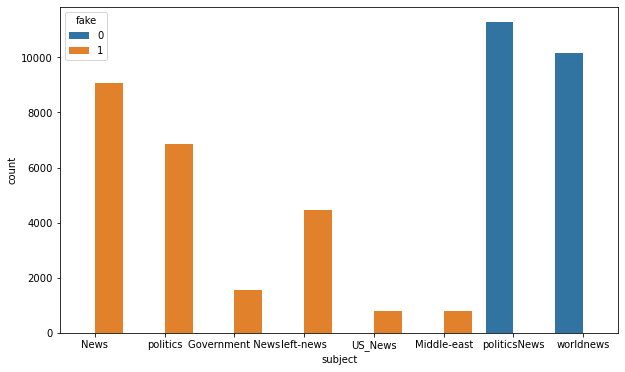

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', data=news, hue='fake')

This clearly shows that any news which is not of "policticsNews or worldnews" is a fake news. This perfectly seggregates the data into two classes and hence is not a choice for classification modelling. We would drop this attribute before we begin modelling